<h1>Time-varying synchrotron spectrum</h1>

In this example we set up a model with a source with a synchrotron spectrum, produced by a family of electrons with a power law energy distribution. We make the index of the electron distribution vary linearly with time, and we let the magnetic field decay as a power law.

In [1]:
from astromodels import *

# Set up the particle distribution for the electrons

my_particle_distribution = log_parabola()

electrons = ParticleSource('electrons',distribution_shape = my_particle_distribution)

# Set the parameters
# (using .set() allows to specify units)
my_particle_distribution.K = 1e35 / u.eV
my_particle_distribution.alpha = -0.75
my_particle_distribution.beta = 0.5

# Now set up the synch. spectrum for our source and the source itself

synch_spectrum = synchrotron()

# Set the magnetic field

synch_spectrum.B = 125 * u.uG

# Use the particle distribution we created as source for the electrons
# producing synch. emission

synch_spectrum.particle_distribution = my_particle_distribution

# Create a point source with the synch. spectrum we just created

synch_source = PointSource('synch_source',ra=12.6, dec=-13.5, spectral_shape=synch_spectrum)

# Create the model (note that we need to include the electron source as well)

my_model = Model(electrons, synch_source)

my_model.display()

name,value,min_value,max_value,unit,delta,free
electrons.spectrum.main.log_parabola.K,1e+38,None,None,1 / keV,0.3,True
electrons.spectrum.main.log_parabola.alpha,-0.75,None,None,,0.6,True
electrons.spectrum.main.log_parabola.beta,0.5,None,None,,0.3,True
synch_source.spectrum.main.synchrotron.B,0.000125,None,None,G,9.72e-07,True
synch_source.spectrum.main.synchrotron.distance,1.0,None,None,kpc,0.3,True


In [9]:
# Now make the model time-dependent by adding the independent variable time

time = IndependentVariable("time", 1, astromodels_units.time)

my_model.add_independent_variable(time)

# Make the magnetic field decay as a power law

my_model.link(my_model.synch_source.spectrum.main.synchrotron.B,
             time,
             powerlaw(K=0.000125, index=-1.0))

# Make the index of the electron distribution increase linearly with time

my_model.link(my_model.electrons.spectrum.main.log_parabola.beta,
             time,
             line(a=-3.2e-3,b=0.0))

# Display the model, which will now feature our linked parameters as well as the parameters
# of the laws we used to link them
my_model.display()

Point sources: synch_source

Extended sources: (none)

Particle sources: electrons

Free parameters:
                          name                           value   ... delta free
------------------------------------------------------- -------- ... ----- ----
                 electrons.spectrum.main.log_parabola.K    1e+38 ...   0.3 True
             electrons.spectrum.main.log_parabola.alpha    -0.75 ...   0.6 True
       electrons.spectrum.main.log_parabola.beta.line.a  -0.0032 ...   0.3 True
       electrons.spectrum.main.log_parabola.beta.line.b      0.0 ...   0.1 True
    synch_source.spectrum.main.synchrotron.B.powerlaw.K 0.000125 ...   0.3 True
synch_source.spectrum.main.synchrotron.B.powerlaw.index     -1.0 ...   0.6 True
        synch_source.spectrum.main.synchrotron.distance      1.0 ...   0.3 True


Linked parameters:
                   name                   linked to function current value unit
----------------------------------------- --------- -------- ------------- ----
electrons.spectrum.main.log_parabola.beta      time     line       -0.0032     
 synch_source.spectrum.main.synchrotron.B      time powerlaw      0.000125    G

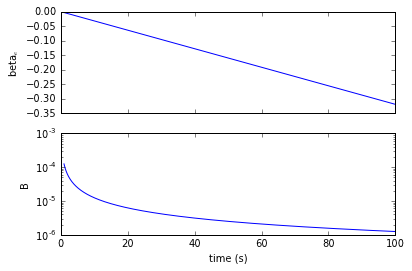

In [10]:
# Let's plot the two parameters as a function of time

import matplotlib.pyplot as plt

# This is needed only in the IPython notebook
%matplotlib inline

times = np.linspace(1,100,1000)

p1 = my_model['electrons.spectrum.main.log_parabola.beta']
p2 = my_model['synch_source.spectrum.main.synchrotron.B']

fig, subs = plt.subplots(2,1, sharex=True)

for sub, par, label in zip(subs,[p1,p2],[r'beta${_e}$',r'B']):
    
    lc = []
    
    for t in times:
    
        time.value = t * u.s
    
        lc.append(par.value.value)

    sub.plot(times, lc)    
    sub.set_ylabel(label)

subs[-1].set_xlabel('time (s)')

subs[-1].set_yscale("log")

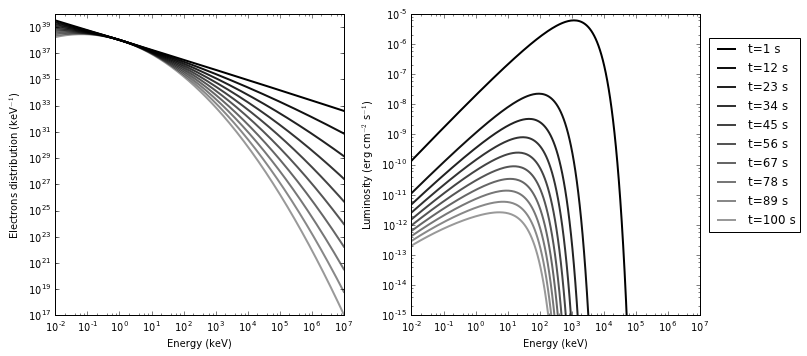

In [11]:
# Let's plot the particle distribution as well as the 
# synch. spectrum at different times

particle_energies = np.logspace(-2,7,200)

energies = np.logspace(-2,7,200)

times = np.linspace(1,100,10)

#s = my_model.synch_source.spectrum.main(energies)

fig, subs = plt.subplots(1,2, figsize=(10,5))

handles = []
labels = []

X = np.zeros((times.shape[0], energies.shape[0]))
Y = np.zeros_like(X)
Z = np.zeros_like(X)

for i,tt in enumerate(times):
    
    my_model['time'].value = tt
    
    s = my_model.synch_source.spectrum.main(energies)
    
    handle = subs[1].loglog(energies, energies*energies*s*1.602e-9,
                            alpha=1-float(i)/15.0, color='black',linewidth=2)
    
    labels.append('t=%.0f s' % tt)
    handles.append(handle[0])
    
    e = my_model.electrons.spectrum.main(particle_energies)
    
    subs[0].loglog(particle_energies, e,
                  alpha=1-float(i)/15.0, color='black',linewidth=2)
    
    Z[i, :] = np.maximum(energies*energies*s*1.602e-9, 1e-17)

subs[1].set_ylim([1e-15,None])
subs[1].set_xlabel("Energy (%s)" % astromodels_units.energy)
subs[1].set_ylabel(r"Luminosity (erg cm$^{-2}$ s$^{-1}$)")

fig.legend(handles, labels, bbox_to_anchor=(1.12, 0.9),loc = 'upper right')
plt.subplots_adjust(left=0.07, right=0.93, wspace=0.25, hspace=0.35)

subs[0].set_xlabel("Energy (%s)" % astromodels_units.energy)
subs[0].set_ylabel(r"Electrons distribution (%s$^{-1}$)" % astromodels_units.energy)

plt.tight_layout()

In [12]:
my_model.save("naima_test.yml",overwrite=True)

In [13]:
my_model = load_model("naima_test.yml")

In [14]:
import scipy.interpolate

interpolator = scipy.interpolate.interp2d(np.log10(energies), times, np.log10(Z))

(100, 200)
(100, 200)
(100, 200)


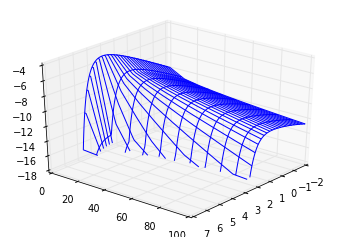

In [15]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X,Y = np.meshgrid(np.log10(energies), np.linspace(0,100,100))

ZZ = interpolator(np.log10(energies), np.linspace(0,100,100))

print X.shape
print Y.shape
print ZZ.shape

ax.azim = 40.0
ax.elev = 30.0

idx = ZZ <= -17
ZZ[idx] = np.nan

ax.plot_wireframe(X, Y, ZZ, rstride=10, cstride=5)

#ax.set_zlim([-17,None])
#ax.set_ylim([-2,6])

nan
nan
